In [1]:
import os
import time
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "Data"
TRAIN_PATH = os.path.join(DATA_DIR, "train-dset.parquet")
TEST_PATH = os.path.join(DATA_DIR, "test-dset-small.parquet")

# 1. –†–∞–∑–º–µ—Ä—ã

In [3]:
t0 = time.time()

train_lf = pl.scan_parquet(TRAIN_PATH)
test_lf = pl.scan_parquet(TEST_PATH)


train = train_lf.collect(streaming=True)
test = test_lf.collect(streaming=True)

print(f"[load] train: {train.shape}, test: {test.shape}, time: {time.time()-t0:.2f}s\n")

C:\Users\idine\AppData\Local\Temp\ipykernel_50252\19000350.py:7: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  train = train_lf.collect(streaming=True)
C:\Users\idine\AppData\Local\Temp\ipykernel_50252\19000350.py:8: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  test = test_lf.collect(streaming=True)


[load] train: (7781790, 14), test: (335348, 13), time: 5.03s



# 2. C—Ö–µ–º–∞

In [4]:
print("[schema] dtypes (train):")
for k, v in train.schema.items():
    print(f"  {k}: {v}")
print()

[schema] dtypes (train):
  query_id: Int64
  item_id: Int64
  query_text: String
  item_title: String
  item_description: String
  query_cat: Float32
  query_mcat: Float64
  query_loc: Float32
  item_cat_id: Int32
  item_mcat_id: Int32
  item_loc: Int32
  price: Float32
  item_query_click_conv: Float32
  item_contact: Float32



In [5]:
list(train['query_text'].unique())

['–æ–±–∏–≤–∫–∞ –∫–≤–∞—Ä—Ç–∏—Ä—ã –¥–≤–µ—Ä–µ–π',
 'labubu yoga',
 '–¥–≤—É—Ö–∫–æ–º–Ω–∞—è –∫–æ–º–Ω–∞—Ç–∞',
 '–ø–ª–∏—Ç–∫–∞ —Å –∑–æ–ª–æ—Ç–æ–º',
 '–≤–∏–¥–µ–æ–∫–∞—Ä—Ç—ã –¥–µ—à–µ–≤—ã–µ',
 'robot coupe',
 '—Ä–µ–º–æ–Ω—Ç –∫–∞–±–µ–ª—å–Ω–æ–≥–æ —Ç–µ–ª–µ–≤–∏–¥–µ–Ω–∏—è',
 '–∫–æ–≤—Ä–∏–∫ –¥–ª—è –Ω–∞–º–∞–∑–∞',
 '–ª–µ–Ω–æ–ª–∏—É–º –±/—É',
 '–∫–µ—Ä–∞–º–æ–≥—Ä–∞–Ω–∏—Ç —Å–µ—Ä—ã–π 42/42',
 '–≤–µ—Ç—Ä–æ–≤–∫–∞ –º–µ–º–±—Ä–∞–Ω–∞',
 '–∞—Ä–µ–Ω–¥–∞ –∫–æ–ª–æ–Ω–∫–∞ jbl',
 '—Ä–∞–º–∫–∏ —Ñ—Å–æ',
 '–∫—É–ø–∏—Ç—å –∑–∏–º–Ω—é—é —Ä–µ–∑–∏–Ω—É –Ω–æ—Ä–¥–º–∞–Ω r-16',
 '–Ω—Ö–ª ps4',
 '—Ñ–∞—Ä–∞ scania 5 —Å–µ—Ä–∏—è',
 '–∫—É–ø–∏—Ç—å –∫–≤–∞—Ä—Ç–∏—Ä—É –Ω–∞ –ø–∞—Ä—Ö–æ–º–µ–Ω–∫–æ',
 '–∫–∏—è –æ–ø—Ç–∏–º–∞ —Ñ–æ–Ω–∞—Ä–∏',
 '—é–±–∫–∞ —á–µ—Ä–Ω–∞—è –∫–æ—Ä–æ—Ç–∫–∞—è –Ω–∞ —Ä–µ–∑–∏–Ω–∫–µ',
 'w —à—Ç–∞–Ω–≥–∞',
 '–æ–±—É–≤—å —à–∫–æ–ª—å–Ω–∞—è –¥–ª—è –¥–µ–≤–æ—á–∫–∏ 31',
 '–∞–≤—Ç–æ—à–∫–æ–ª–∞',
 '–ª–æ–¥–∫–∞ –∫–∞–∑–∞–Ω–∫–∞',
 '–∫–≤–∞–¥—Ä–æ—Ü–∏–∫–ª –±–µ–Ω–∑–∏–Ω–æ–≤—ã–π –¥–µ—Ç—Å–∫–∏–π 50 –∫—É–±–æ–≤',
 '–∫–æ—Ç—è—Ç–∞ –ø–∞—Ä–æ–¥–∏—Å—Ç—ã–µ',
 '—à—É–±—ã –æ–ø—Ç–æ–º —ç–∫

# 3. –ü—Ä–æ–ø—É—Å–∫–∏

In [6]:
missing = (
    train
    .select([pl.col(c).is_null().sum().alias(c) for c in train.columns])
    .transpose(include_header=True, header_name="column", column_names=["nulls"])
    .with_columns([
        (pl.col("nulls") / train.height).alias("null_frac")
    ])
    .sort("nulls", descending=True)
)
print("[missing] –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏ –¥–æ–ª—è –ø—Ä–æ–ø—É—Å–∫–æ–≤ –ø–æ –∫–æ–ª–æ–Ω–∫–∞–º:")
missing


[missing] –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∏ –¥–æ–ª—è –ø—Ä–æ–ø—É—Å–∫–æ–≤ –ø–æ –∫–æ–ª–æ–Ω–∫–∞–º:


shape: (14, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ column                ‚îÜ nulls   ‚îÜ null_frac ‚îÇ
‚îÇ ---                   ‚îÜ ---     ‚îÜ ---       ‚îÇ
‚îÇ str                   ‚îÜ u32     ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ query_mcat            ‚îÜ 1761233 ‚îÜ 0.226327  ‚îÇ
‚îÇ item_title            ‚îÜ 107     ‚îÜ 0.000014  ‚îÇ
‚îÇ item_description      ‚îÜ 107     ‚îÜ 0.000014  ‚îÇ
‚îÇ query_id              ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ item_id               ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ ‚Ä¶                     ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ item_mcat_id          ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ item_loc              ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ price                 ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ item_query_click_conv ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ item_contact          ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [7]:
print(missing)

shape: (14, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ column                ‚îÜ nulls   ‚îÜ null_frac ‚îÇ
‚îÇ ---                   ‚îÜ ---     ‚îÜ ---       ‚îÇ
‚îÇ str                   ‚îÜ u32     ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ query_mcat            ‚îÜ 1761233 ‚îÜ 0.226327  ‚îÇ
‚îÇ item_title            ‚îÜ 107     ‚îÜ 0.000014  ‚îÇ
‚îÇ item_description      ‚îÜ 107     ‚îÜ 0.000014  ‚îÇ
‚îÇ query_id              ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ item_id               ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ ‚Ä¶                     ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ item_mcat_id          ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ item_loc              ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ price                 ‚îÜ 0       ‚îÜ 0.0       ‚îÇ
‚îÇ item_query_click_co

# 4. –£–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è

In [8]:
def nunique(df: pl.DataFrame, col: str) -> int:
    return df.select(pl.col(col).n_unique()).item()

print("[unique] —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö query_id (train/test):", nunique(train, "query_id"), nunique(test, "query_id"))
print("[unique] —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö item_id   (train/test):", nunique(train, "item_id"), nunique(test, "item_id"))
print()

[unique] —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö query_id (train/test): 678190 12505
[unique] —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö item_id   (train/test): 5773058 321625



# –ß–∏—Å–ª–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ

In [9]:
num_cols = [c for c, t in train.schema.items() if t in pl.NUMERIC_DTYPES]
if num_cols:
    # –î–ª—è –∫–æ–º–ø–∞–∫—Ç–Ω–æ—Å—Ç–∏ —Å—á–∏—Ç–∞–µ–º –Ω–∞–±–æ—Ä —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫ –ø–æ –∫–∞–∂–¥–æ–π —á–∏—Å–ª–æ–≤–æ–π –∫–æ–ª–æ–Ω–∫–µ
    stats_rows = []
    for c in num_cols:
        s = (
            train
            .select(
                pl.col(c).cast(pl.Float64),
                pl.len().alias("__n")
            )
            .select([
                pl.lit(c).alias("column"),
                pl.col(c).mean().alias("mean"),
                pl.col(c).std().alias("std"),
                pl.col(c).min().alias("min"),
                pl.col(c).quantile(0.25).alias("p25"),
                pl.col(c).median().alias("p50"),
                pl.col(c).quantile(0.75).alias("p75"),
                pl.col(c).quantile(0.95).alias("p95"),
                pl.col(c).quantile(0.99).alias("p99"),
                pl.col(c).max().alias("max"),
            ])
        )
        stats_rows.append(s)
    num_stats = pl.concat(stats_rows)
    print("[numeric] –±–∞–∑–æ–≤—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏:")
    res = num_stats.sort("column")

C:\Users\idine\AppData\Local\Temp\ipykernel_50252\1822074572.py:1: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  num_cols = [c for c, t in train.schema.items() if t in pl.NUMERIC_DTYPES]


[numeric] –±–∞–∑–æ–≤—ã–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∏:


In [10]:
res

shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ column    ‚îÜ mean      ‚îÜ std       ‚îÜ min      ‚îÜ ‚Ä¶ ‚îÜ p75       ‚îÜ p95       ‚îÜ p99       ‚îÜ max       ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÜ   ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ str       ‚îÜ f64       ‚îÜ f64       ‚îÜ f64      ‚îÜ   ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ item_cat_ ‚îÜ 58.124696 ‚îÜ 42.391457 ‚îÜ 0.0      ‚îÜ ‚Ä¶ ‚îÜ 111.0     ‚îÜ 114.0     ‚îÜ 114.0     ‚îÜ 426.0     ‚îÇ
‚îÇ id        ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ item_cont ‚îÜ 0.044057  ‚îÜ 0.205223  ‚îÜ 0.0      ‚îÜ ‚Ä¶ ‚îÜ 0.0       ‚îÜ 0.0       ‚îÜ 1.0       ‚îÜ 1.0       ‚îÇ
‚îÇ act       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ item_id   ‚îÜ 5.9148e9  ‚îÜ 2.0082e9  ‚îÜ 112067.0 ‚îÜ ‚Ä¶ ‚îÜ 7.5281e9  ‚îÜ 7.5834e9  ‚îÜ 7.6078e9  ‚îÜ 7.6620e9  ‚îÇ
‚îÇ item_loc  ‚îÜ 644144.20 ‚îÜ 20381.792 ‚îÜ 621551.0 ‚îÜ ‚Ä¶ ‚îÜ 653240.0  ‚îÜ 661010.0  ‚îÜ 662810.0  ‚îÜ 905811.0  ‚îÇ
‚îÇ           ‚îÜ 2853      ‚îÜ 652       ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ item_mcat ‚îÜ 1.0722e6  ‚îÜ 1.0320e6  ‚îÜ 0.0      ‚îÜ ‚Ä¶ ‚îÜ 2.275142e ‚îÜ 2.30187e6 ‚îÜ 2.302905e ‚îÜ 2.303084e ‚îÇ
‚îÇ _id       ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ   ‚îÜ 6         ‚îÜ           ‚îÜ 6         ‚îÜ 6         ‚îÇ
‚îÇ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ price     ‚îÜ 1.5637e6  ‚îÜ 9.4102e8  ‚îÜ 0.0      ‚îÜ ‚Ä¶ ‚îÜ 13100.0   ‚îÜ 310000.0  ‚îÜ 4.6e6     ‚îÜ 1.0000e12 ‚îÇ
‚îÇ query_cat ‚îÜ 44.657394 ‚îÜ 48.492066 ‚îÜ 0.0      ‚îÜ ‚Ä¶ ‚îÜ 106.0     ‚îÜ 114.0     ‚îÜ 114.0     ‚îÜ 442.0     ‚îÇ
‚îÇ query_id  ‚îÜ 412381.94 ‚îÜ 238226.16 ‚îÜ 0.0      ‚îÜ ‚Ä¶ ‚îÜ 618746.0  ‚îÜ 783362.0  ‚îÜ 816492.0  ‚îÜ 824764.0  ‚îÇ
‚îÇ           ‚îÜ 137       ‚îÜ 3007      ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ query_loc ‚îÜ 500751.06 ‚îÜ 259933.16 ‚îÜ 0.0      ‚îÜ ‚Ä¶ ‚îÜ 651280.0  ‚îÜ 660060.0  ‚îÜ 662530.0  ‚îÜ 904768.0  ‚îÇ
‚îÇ           ‚îÜ 7443      ‚îÜ 4784      ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ query_mca ‚îÜ 341416.33 ‚îÜ 742911.39 ‚îÜ 2.0      ‚îÜ ‚Ä¶ ‚îÜ 3838.0    ‚îÜ 2.301062e ‚îÜ 2.302905e ‚îÜ 2.303049e ‚îÇ
‚îÇ t         ‚îÜ 937       ‚îÜ 3274      ‚îÜ          ‚îÜ   ‚îÜ           ‚îÜ 6         ‚îÜ 6         ‚îÜ 6         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [11]:
print(res)

shape: (11, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ column    ‚îÜ mean      ‚îÜ std       ‚îÜ min      ‚îÜ ‚Ä¶ ‚îÜ p75       ‚îÜ p95       ‚îÜ p99       ‚îÜ max       ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÜ   ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ str       ‚îÜ f64       ‚îÜ f64       ‚îÜ f64      ‚îÜ   ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ item_cat_ ‚îÜ

# –¢–∞—Ä–≥–µ—Ç: –±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤

In [12]:
if "item_contact" in train.columns:
    tgt = (
        train
        .with_columns(pl.col("item_contact").cast(pl.Int32))
        .group_by("item_contact")
        .agg(pl.len().alias("cnt"))
        .with_columns((pl.col("cnt") / pl.col("cnt").sum()).alias("frac"))
        .sort("item_contact")
    )
    print("[target] —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ item_contact:")
    print(f"[target] –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–∞—è –¥–æ–ª—è: {train.select(pl.col('item_contact').cast(pl.Float64).mean()).item():.4f}\n")

[target] —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ item_contact:
[target] –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω–∞—è –¥–æ–ª—è: 0.0441



In [13]:
tgt

shape: (2, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ item_contact ‚îÜ cnt     ‚îÜ frac     ‚îÇ
‚îÇ ---          ‚îÜ ---     ‚îÜ ---      ‚îÇ
‚îÇ i32          ‚îÜ u32     ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0            ‚îÜ 7438944 ‚îÜ 0.955943 ‚îÇ
‚îÇ 1            ‚îÜ 342846  ‚îÜ 0.044057 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [14]:
print(tgt)

shape: (2, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ item_contact ‚îÜ cnt     ‚îÜ frac     ‚îÇ
‚îÇ ---          ‚îÜ ---     ‚îÜ ---      ‚îÇ
‚îÇ i32          ‚îÜ u32     ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0            ‚îÜ 7438944 ‚îÜ 0.955943 ‚îÇ
‚îÇ 1            ‚îÜ 342846  ‚îÜ 0.044057 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


# –ì—Ä—É–ø–ø—ã –ø–æ –∑–∞–ø—Ä–æ—Å–∞–º: —Ä–∞–∑–º–µ—Ä –ø—É–ª–∞, –¥–æ–ª—è –ø–æ–∑–∏—Ç–∏–≤–æ–≤, —Ü–µ–Ω–∞ –≤–Ω—É—Ç—Ä–∏ –∑–∞–ø—Ä–æ—Å–∞

In [15]:
if "item_contact" in train.columns and "price" in train.columns:
    per_query = (
        train
        .with_columns(pl.col("item_contact").cast(pl.Int32))
        .group_by("query_id")
        .agg([
            pl.len().alias("n_items"),
            pl.col("item_contact").sum().alias("n_pos"),
            pl.col("item_contact").mean().alias("pos_rate"),
            pl.col("price").mean().alias("price_mean"),
            pl.col("price").median().alias("price_median")
        ])
        .sort("n_items", descending=True)
    )
    print("[group] –ø—Ä–∏–º–µ—Ä—ã –∞–≥—Ä–µ–≥–∞—Ç–æ–≤ –ø–æ query_id:")
    print(per_query.head(10))
    print()

    # –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ä–∞–∑–º–µ—Ä–∞ –ø—É–ª–æ–≤ –∏ –¥–æ–ª–∏ –ø–æ–∑–∏—Ç–∏–≤–æ–≤ (–≤ —á–∏—Å–ª–∞—Ö)
    print("[group] —Ä–∞–∑–º–µ—Ä –ø—É–ª–∞ –∫–∞–Ω–¥–∏–¥–∞—Ç–æ–≤ (–∫–≤–∞–Ω—Ç–∏–ª–∏):")
    print(per_query.select([
        pl.col("n_items").min().alias("min"),
        pl.col("n_items").quantile(0.5).alias("p50"),
        pl.col("n_items").quantile(0.9).alias("p90"),
        pl.col("n_items").quantile(0.99).alias("p99"),
        pl.col("n_items").max().alias("max"),
    ]))
    print()

[group] –ø—Ä–∏–º–µ—Ä—ã –∞–≥—Ä–µ–≥–∞—Ç–æ–≤ –ø–æ query_id:
shape: (10, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ query_id ‚îÜ n_items ‚îÜ n_pos ‚îÜ pos_rate ‚îÜ price_mean    ‚îÜ price_median ‚îÇ
‚îÇ ---      ‚îÜ ---     ‚îÜ ---   ‚îÜ ---      ‚îÜ ---           ‚îÜ ---          ‚îÇ
‚îÇ i64      ‚îÜ u32     ‚îÜ i32   ‚îÜ f64      ‚îÜ f32           ‚îÜ f32          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 757116   ‚îÜ 500     ‚îÜ 6     ‚îÜ 0.012    ‚îÜ 20046.0       ‚îÜ 0.0          ‚îÇ
‚îÇ 636573   ‚îÜ 480     ‚îÜ 0     ‚îÜ 0.0      ‚îÜ 31602.707031  ‚îÜ 10000.0      ‚îÇ
‚îÇ 762063   ‚îÜ 478     ‚îÜ 0     ‚îÜ 0.0      ‚îÜ 20771.8

 # –ö–∞—Ç–µ–≥–æ—Ä–∏–∏ –∏ –ª–æ–∫–∞—Ü–∏–∏

In [16]:
for a, b, name in [
    ("query_cat", "item_cat_id", "cat_match"),
    ("query_mcat", "item_mcat_id", "mcat_match"),
    ("query_loc", "item_loc", "loc_match"),
]:
    if a in train.columns and b in train.columns:
        rate = (
            train
            .with_columns((pl.col(a) == pl.col(b)).alias(name))
            .select(pl.col(name).cast(pl.Int32).mean())
            .item()
        )
        print(f"[match] –¥–æ–ª—è —Å–æ–≤–ø–∞–¥–µ–Ω–∏–π {a} == {b}: {rate:.4f}")
print()

[match] –¥–æ–ª—è —Å–æ–≤–ø–∞–¥–µ–Ω–∏–π query_cat == item_cat_id: 0.6985
[match] –¥–æ–ª—è —Å–æ–≤–ø–∞–¥–µ–Ω–∏–π query_mcat == item_mcat_id: 0.3921
[match] –¥–æ–ª—è —Å–æ–≤–ø–∞–¥–µ–Ω–∏–π query_loc == item_loc: 0.4853



In [17]:
def topk(df: pl.DataFrame, col: str, k: int = 10) -> pl.DataFrame:
    return df.group_by(col).agg(pl.len().alias("cnt")).sort("cnt", descending=True).head(k)

for col in ["query_cat", "query_mcat", "query_loc", "item_cat_id", "item_mcat_id", "item_loc"]:
    if col in train.columns:
        print(f"[top] {col}:")
        print(topk(train, col, 10))
        print()

[top] query_cat:
shape: (10, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ query_cat ‚îÜ cnt     ‚îÇ
‚îÇ ---       ‚îÜ ---     ‚îÇ
‚îÇ f32       ‚îÜ u32     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0.0       ‚îÜ 1747975 ‚îÇ
‚îÇ 114.0     ‚îÜ 693215  ‚îÇ
‚îÇ 27.0      ‚îÜ 679839  ‚îÇ
‚îÇ 112.0     ‚îÜ 652631  ‚îÇ
‚îÇ 10.0      ‚îÜ 546969  ‚îÇ
‚îÇ 111.0     ‚îÜ 458653  ‚îÇ
‚îÇ 29.0      ‚îÜ 283786  ‚îÇ
‚îÇ 9.0       ‚îÜ 242959  ‚îÇ
‚îÇ 5.0       ‚îÜ 219190  ‚îÇ
‚îÇ 24.0      ‚îÜ 188211  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

[top] query_mcat:
shape: (10, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ query_mcat ‚îÜ cnt     ‚îÇ
‚îÇ ---        ‚îÜ ---     ‚îÇ
‚îÇ f64        ‚îÜ u32     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ null       ‚îÜ 1761233 ‚îÇ
‚îÇ 62.0       ‚îÜ 652631  ‚îÇ
‚îÇ 61.0       ‚îÜ 456171  ‚îÇ
‚î

# –¢–µ–∫—Å—Ç—ã

In [18]:
text_cols = [c for c, t in train.schema.items() if t == pl.Utf8]
has_text = all(x in train.columns for x in ["query_text", "item_title", "item_description"])

if has_text:
    # –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞: –Ω–∏–∂–Ω–∏–π —Ä–µ–≥–∏—Å—Ç—Ä, –æ—á–∏—Å—Ç–∫–∞, —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –ø–æ –ø—Ä–æ–±–µ–ª–∞–º
    # –†–µ–≥—É–ª—è—Ä–∫–∞ —É–¥–∞–ª—è–µ—Ç –≤—Å–µ –Ω–µ-–±—É–∫–≤–µ–Ω–Ω–æ-—Ü–∏—Ñ—Ä–æ–≤—ã–µ —Å–∏–º–≤–æ–ª—ã, —Å–≤–æ–¥–∏—Ç –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ –∫ –æ–¥–Ω–æ–º—É –ø—Ä–æ–±–µ–ª—É.
    def tokenize(col: str) -> pl.Expr:
        return (
            pl.col(col)
            .cast(pl.Utf8)
            .fill_null("")
            .str.to_lowercase()
            .str.replace_all(r"[^0-9\p{L}]+", " ")
            .str.strip_chars()  # <--- –∑–∞–º–µ–Ω–∞ .strip()
            .str.split(" ")
            .list.eval(pl.element().filter(pl.element() != ""))  # —É–±–∏—Ä–∞–µ–º –ø—É—Å—Ç—ã–µ
        )


    train = train.with_columns([
        tokenize("query_text").alias("query_tokens"),
        tokenize("item_title").alias("title_tokens"),
        tokenize("item_description").alias("desc_tokens"),
    ])

    # –î–ª–∏–Ω—ã –≤ —Å–ª–æ–≤–∞—Ö
    train = train.with_columns([
        pl.col("query_tokens").list.len().alias("query_len"),
        pl.col("title_tokens").list.len().alias("title_len"),
        pl.col("desc_tokens").list.len().alias("desc_len"),
    ])

    print("[text] –∫–≤–∞–Ω—Ç–∏–ª–∏ –¥–ª–∏–Ω (—Å–ª–æ–≤):")
    print(
        train.select([
            pl.col("query_len").quantile(0.5).alias("query_p50"),
            pl.col("query_len").quantile(0.95).alias("query_p95"),
            pl.col("title_len").quantile(0.5).alias("title_p50"),
            pl.col("title_len").quantile(0.95).alias("title_p95"),
            pl.col("desc_len").quantile(0.5).alias("desc_p50"),
            pl.col("desc_len").quantile(0.95).alias("desc_p95"),
        ])
    )
    print()

    # –ü–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ —Ç–æ–∫–µ–Ω–æ–≤ –º–µ–∂–¥—É –∑–∞–ø—Ä–æ—Å–æ–º –∏ –∑–∞–≥–æ–ª–æ–≤–∫–æ–º/–æ–ø–∏—Å–∞–Ω–∏–µ–º
    # –ò—Å–ø–æ–ª—å–∑—É–µ–º set_intersection –¥–ª—è —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Ç–æ–∫–µ–Ω–æ–≤
    train = train.with_columns([
        pl.col("query_tokens").list.set_intersection(pl.col("title_tokens")).list.len().alias("overlap_q_title"),
        pl.col("query_tokens").list.set_intersection(pl.col("desc_tokens")).list.len().alias("overlap_q_desc"),
    ])

    print("[text] —Å—Ä–µ–¥–Ω–µ–µ –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ —Ç–æ–∫–µ–Ω–æ–≤:")
    print(
        train.select([
            pl.col("overlap_q_title").mean().alias("mean_overlap_q_title"),
            pl.col("overlap_q_desc").mean().alias("mean_overlap_q_desc"),
        ])
    )
    print()


[text] –∫–≤–∞–Ω—Ç–∏–ª–∏ –¥–ª–∏–Ω (—Å–ª–æ–≤):
shape: (1, 6)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ query_p50 ‚îÜ query_p95 ‚îÜ title_p50 ‚îÜ title_p95 ‚îÜ desc_p50 ‚îÜ desc_p95 ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---       ‚îÜ ---      ‚îÜ ---      ‚îÇ
‚îÇ f64       ‚îÜ f64       ‚îÜ f64       ‚îÜ f64       ‚îÜ f64      ‚îÜ f64      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2.0       ‚îÜ 5.0       ‚îÜ 5.0       ‚îÜ 9.0       ‚îÜ 49.0     ‚îÜ 146.0    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

# –ü–æ–≤–µ–¥–µ–Ω—á–µ—Å–∫–∏–π —Å–∏–≥–Ω–∞–ª vs —Ç–∞—Ä–≥–µ—Ç

In [19]:
if "item_query_click_conv" in train.columns and "item_contact" in train.columns:
    # –ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –ü–∏—Ä—Å–æ–Ω–∞ (item_contact –ø—Ä–∏–≤–æ–¥–∏–º –∫ float)
    corr = train.select(pl.corr(pl.col("item_query_click_conv"), pl.col("item_contact").cast(pl.Float64))).item()
    print(f"[corr] corr(item_query_click_conv, item_contact): {corr:.4f}")

    # –°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è 0/1
    by_target = (
        train
        .with_columns(pl.col("item_contact").cast(pl.Int32))
        .group_by("item_contact")
        .agg(pl.col("item_query_click_conv").mean().alias("conv_mean"))
        .sort("item_contact")
    )
    print("[conv] —Å—Ä–µ–¥–Ω–µ–µ conv –ø–æ –∫–ª–∞—Å—Å–∞–º item_contact:")
    print(by_target)
    print()


[corr] corr(item_query_click_conv, item_contact): 0.0190
[conv] —Å—Ä–µ–¥–Ω–µ–µ conv –ø–æ –∫–ª–∞—Å—Å–∞–º item_contact:
shape: (2, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ item_contact ‚îÜ conv_mean ‚îÇ
‚îÇ ---          ‚îÜ ---       ‚îÇ
‚îÇ i32          ‚îÜ f32       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0            ‚îÜ -0.839106 ‚îÇ
‚îÇ 1            ‚îÜ -0.803783 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò



In [20]:
def sample_for_plots(df: pl.DataFrame, n: int = 200_000, seed: int = 42) -> pl.DataFrame:
    if df.height <= n:
        return df
    return df.sample(n=n, shuffle=True, seed=seed)

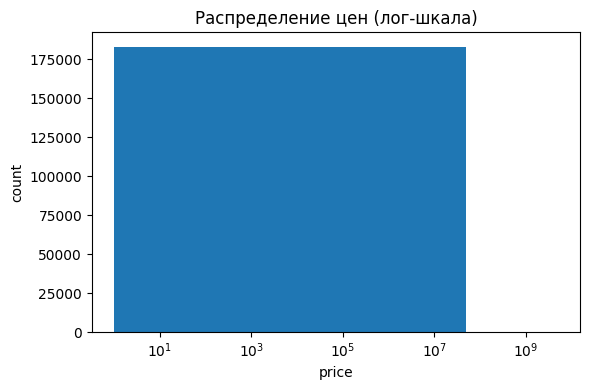

In [21]:
plot_df = sample_for_plots(train)

# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ —Ü–µ–Ω (–ª–æ–≥-—à–∫–∞–ª–∞)
if "price" in plot_df.columns:
    price_vals = plot_df.select(pl.col("price").cast(pl.Float64)).to_series().to_numpy()
    price_vals = price_vals[np.isfinite(price_vals) & (price_vals > 0)]
    if len(price_vals) > 0:
        plt.figure(figsize=(6, 4))
        plt.hist(price_vals, bins=100)
        plt.xscale("log")
        plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–Ω (–ª–æ–≥-—à–∫–∞–ª–∞)")
        plt.xlabel("price")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

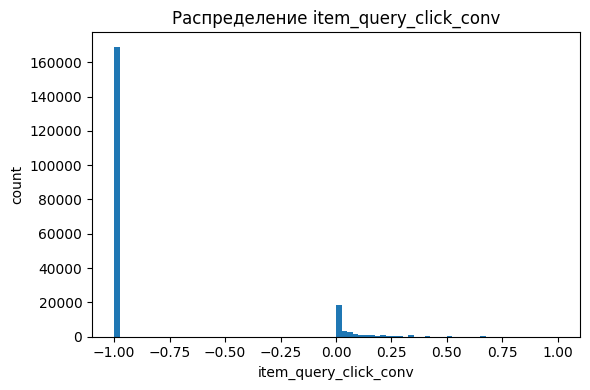

In [22]:
# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ item_query_click_conv
if "item_query_click_conv" in plot_df.columns:
    conv_vals = plot_df.select(pl.col("item_query_click_conv").cast(pl.Float64)).to_series().to_numpy()
    conv_vals = conv_vals[np.isfinite(conv_vals)]
    if len(conv_vals) > 0:
        plt.figure(figsize=(6, 4))
        plt.hist(conv_vals, bins=80)
        plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ item_query_click_conv")
        plt.xlabel("item_query_click_conv")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()


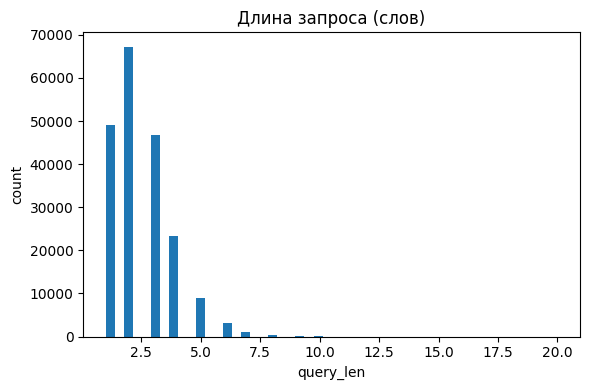

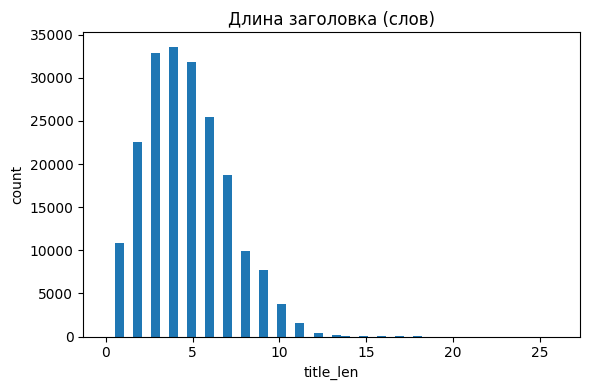

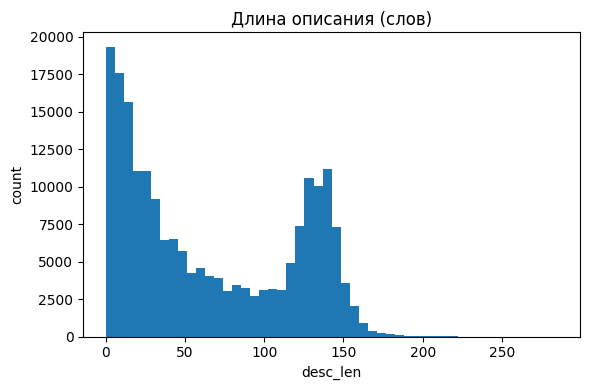

In [23]:
# –î–ª–∏–Ω—ã —Ç–µ–∫—Å—Ç–æ–≤
if has_text:
    q_len = plot_df.select(pl.col("query_len").cast(pl.Float64)).to_series().to_numpy()
    t_len = plot_df.select(pl.col("title_len").cast(pl.Float64)).to_series().to_numpy()
    d_len = plot_df.select(pl.col("desc_len").cast(pl.Float64)).to_series().to_numpy()

    plt.figure(figsize=(6, 4))
    plt.hist(q_len[np.isfinite(q_len)], bins=50)
    plt.title("–î–ª–∏–Ω–∞ –∑–∞–ø—Ä–æ—Å–∞ (—Å–ª–æ–≤)")
    plt.xlabel("query_len")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(t_len[np.isfinite(t_len)], bins=50)
    plt.title("–î–ª–∏–Ω–∞ –∑–∞–≥–æ–ª–æ–≤–∫–∞ (—Å–ª–æ–≤)")
    plt.xlabel("title_len")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(d_len[np.isfinite(d_len)], bins=50)
    plt.title("–î–ª–∏–Ω–∞ –æ–ø–∏—Å–∞–Ω–∏—è (—Å–ª–æ–≤)")
    plt.xlabel("desc_len")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

In [24]:
test.head(5)

shape: (5, 13)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ query_id ‚îÜ item_id    ‚îÜ query_text ‚îÜ item_title ‚îÜ ‚Ä¶ ‚îÜ item_mcat_ ‚îÜ item_loc ‚îÜ price  ‚îÜ item_quer ‚îÇ
‚îÇ ---      ‚îÜ ---        ‚îÜ ---        ‚îÜ ---        ‚îÜ   ‚îÜ id         ‚îÜ ---      ‚îÜ ---    ‚îÜ y_click_c ‚îÇ
‚îÇ i64      ‚îÜ i64        ‚îÜ str        ‚îÜ str        ‚îÜ   ‚îÜ ---        ‚îÜ i32      ‚îÜ f32    ‚îÜ onv       ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ i32        ‚îÜ          ‚îÜ        ‚îÜ ---       ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ f32       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 55       ‚îÜ 7540855789 ‚îÜ 1 —Å–µ–Ω—Ç—è–±—Ä—è ‚îÜ –í–æ–∑–¥—É—à–Ω—ã–µ  ‚îÜ ‚Ä¶ ‚îÜ 2301564    ‚îÜ 637640   ‚îÜ 120.0  ‚îÜ -1.0      ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ –∏ –≥–µ–ª–∏–µ–≤—ã–µ ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ —à–∞—Ä—ã –Ω–∞ 1‚Ä¶ ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ 55       ‚îÜ 7506720336 ‚îÜ 1 —Å–µ–Ω—Ç—è–±—Ä—è ‚îÜ 1 —Å–µ–Ω—Ç—è–±—Ä—è ‚îÜ ‚Ä¶ ‚îÜ 2301564    ‚îÜ 637640   ‚îÜ 5000.0 ‚îÜ -1.0      ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ —Ñ–æ—Ç–æ–∑–æ–Ω–∞   ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ 55       ‚îÜ 3110733862 ‚îÜ 1 —Å–µ–Ω—Ç—è–±—Ä—è ‚îÜ –ë—É–∫–µ—Ç –Ω–∞ 1 ‚îÜ ‚Ä¶ ‚îÜ 1090077    ‚îÜ 637640   ‚îÜ 1200.0 ‚îÜ -1.0      ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ —Å–µ–Ω—Ç—è–±—Ä—è   ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ –∏–∑ –∑–µ—Ñ–∏—Ä–∞  ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ 55       ‚îÜ 7587733901 ‚îÜ 1 —Å–µ–Ω—Ç—è–±—Ä—è ‚îÜ –°–ø–µ–∫—Ç–∞–∫–ª—å- ‚îÜ ‚Ä¶ ‚îÜ 2301563    ‚îÜ 637640   ‚îÜ 0.0    ‚îÜ -1.0      ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ –ø–∞–Ω—Ç–æ–º–∏–º–∞  ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ –Ω–∞ 1       ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ —Å–µ–Ω—Ç—è‚Ä¶     ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ 55       ‚îÜ 7552455685 ‚îÜ 1 —Å–µ–Ω—Ç—è–±—Ä—è ‚îÜ –í–æ–∑–¥—É—à–Ω—ã–µ  ‚îÜ ‚Ä¶ ‚îÜ 2301564    ‚îÜ 637640   ‚îÜ 100.0  ‚îÜ -1.0      ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ –≥–µ–ª–∏–µ–≤—ã–µ   ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ —à–∞—Ä—ã —Å     ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ            ‚îÜ –¥–æ—Å—Ç‚Ä¶      ‚îÜ   ‚îÜ            ‚îÜ          ‚îÜ        ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [25]:
ex = train.filter(pl.col("query_id") == 757116)
ex

shape: (500, 22)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ query_id ‚îÜ item_id    ‚îÜ query_tex ‚îÜ item_titl ‚îÜ ‚Ä¶ ‚îÜ title_len ‚îÜ desc_len ‚îÜ overlap_q ‚îÜ overlap_q ‚îÇ
‚îÇ ---      ‚îÜ ---        ‚îÜ t         ‚îÜ e         ‚îÜ   ‚îÜ ---       ‚îÜ ---      ‚îÜ _title    ‚îÜ _desc     ‚îÇ
‚îÇ i64      ‚îÜ i64        ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ u32       ‚îÜ u32      ‚îÜ ---       ‚îÜ ---       ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ str       ‚îÜ str       ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ u32       ‚îÜ u32       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 757116   ‚îÜ 7272304632 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä     ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 0        ‚îÜ 1         ‚îÜ 0         ‚îÇ
‚îÇ 757116   ‚îÜ 1911918753 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä     ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 115      ‚îÜ 1         ‚îÜ 0         ‚îÇ
‚îÇ 757116   ‚îÜ 4408324839 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä –≥/—Ü ‚îÜ ‚Ä¶ ‚îÜ 3         ‚îÜ 20       ‚îÜ 1         ‚îÜ 0         ‚îÇ
‚îÇ 757116   ‚îÜ 4600842279 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä     ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 0        ‚îÜ 1         ‚îÜ 0         ‚îÇ
‚îÇ 757116   ‚îÜ 3196572628 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä –º–Ω–µ ‚îÜ ‚Ä¶ ‚îÜ 3         ‚îÜ 0        ‚îÜ 1         ‚îÜ 0         ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ           ‚îÜ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–æ ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ ‚Ä¶        ‚îÜ ‚Ä¶          ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶        ‚îÜ ‚Ä¶         ‚îÜ ‚Ä¶         ‚îÇ
‚îÇ 757116   ‚îÜ 7253759823 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä —Å   ‚îÜ ‚Ä¶ ‚îÜ 3         ‚îÜ 2        ‚îÜ 1         ‚îÜ 0         ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ           ‚îÜ –æ–±—É—á–µ–Ω–∏–µ–º ‚îÜ   ‚îÜ           ‚îÜ          ‚îÜ           ‚îÜ           ‚îÇ
‚îÇ 757116   ‚îÜ 7309049240 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä     ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 0        ‚îÜ 1         ‚îÜ 0         ‚îÇ
‚îÇ 757116   ‚îÜ 7661062654 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä     ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 0        ‚îÜ 1         ‚îÜ 0         ‚îÇ
‚îÇ 757116   ‚îÜ 4489909943 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä     ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 3        ‚îÜ 1         ‚îÜ 1         ‚îÇ
‚îÇ 757116   ‚îÜ 7566079994 ‚îÜ –ø–æ–≤–∞—Ä     ‚îÜ –ü–æ–≤–∞—Ä     ‚îÜ ‚Ä¶ ‚îÜ 1         ‚îÜ 0        ‚îÜ 1         ‚îÜ 0         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [34]:
from typing import List, Dict, Any, Tuple
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ –Ω—É–∂–Ω—ã–µ –∫–æ–ª–æ–Ω–∫–∏ –µ—Å—Ç—å
req_cols = ["query_cat","query_mcat","query_loc","item_cat_id","item_mcat_id","item_loc","item_contact","price","item_query_click_conv"]
print("[check] present:", {c: (c in train.columns) for c in req_cols})

# –£—Ç–∏–ª–∏—Ç—ã
def topk_counts(df: pl.DataFrame, col: str, k: int = 20) -> pl.DataFrame:
    return (df.group_by(col)
              .agg(pl.len().alias("cnt"))
              .sort("cnt", descending=True)
              .head(k))

def frac(x, by):  # —Å—Ä–µ–¥–Ω–µ–µ –ø–æ —É—Å–ª–æ–≤–∏—é (0/1 –∏–ª–∏ —á–∏—Å–ª–æ–≤–æ–µ)
    return x.mean().over(by)

[check] present: {'query_cat': True, 'query_mcat': True, 'query_loc': True, 'item_cat_id': True, 'item_mcat_id': True, 'item_loc': True, 'item_contact': True, 'price': True, 'item_query_click_conv': True}


In [28]:
# –§–ª–∞–≥–∏ –º–∞—Ç—á–µ–π (cat/mcat/loc)
train_cat = (train
    .with_columns([
        (pl.col("query_cat")  == pl.col("item_cat_id")).cast(pl.Int8).alias("cat_match"),
        (pl.col("query_mcat") == pl.col("item_mcat_id")).cast(pl.Int8).alias("mcat_match"),
        (pl.col("query_loc")  == pl.col("item_loc")).cast(pl.Int8).alias("loc_match"),
        pl.col("query_mcat").is_null().cast(pl.Int8).alias("is_query_mcat_missing"),
        pl.col("item_contact").cast(pl.Int8).alias("tgt")
    ])
)

In [29]:
print("[head] with match flags:")
train_cat.head(5)

[head] with match flags:


shape: (5, 27)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ query_id ‚îÜ item_id    ‚îÜ query_text  ‚îÜ item_title ‚îÜ ‚Ä¶ ‚îÜ mcat_match ‚îÜ loc_match ‚îÜ is_query_m ‚îÜ tgt ‚îÇ
‚îÇ ---      ‚îÜ ---        ‚îÜ ---         ‚îÜ ---        ‚îÜ   ‚îÜ ---        ‚îÜ ---       ‚îÜ cat_missin ‚îÜ --- ‚îÇ
‚îÇ i64      ‚îÜ i64        ‚îÜ str         ‚îÜ str        ‚îÜ   ‚îÜ i8         ‚îÜ i8        ‚îÜ g          ‚îÜ i8  ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ             ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ ---        ‚îÜ     ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ             ‚îÜ            ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ i8         ‚îÜ     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 4        ‚îÜ 7349717282 ‚îÜ –±–æ—Ç–∏–Ω–∫–∏     ‚îÜ –ë–æ—Ç–∏–Ω–∫–∏    ‚îÜ ‚Ä¶ ‚îÜ 0          ‚îÜ 0         ‚îÜ 0          ‚îÜ 0   ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ –¥–µ—Ç—Å–∫–∏–µ     ‚îÜ –¥–µ—Ç—Å–∫–∏–µ    ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ zara 21     ‚îÜ Zara       ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ 4        ‚îÜ 7519735286 ‚îÜ –±–æ—Ç–∏–Ω–∫–∏     ‚îÜ –î–µ—Ç—Å–∫–∏–µ    ‚îÜ ‚Ä¶ ‚îÜ 0          ‚îÜ 0         ‚îÜ 0          ‚îÜ 0   ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ –¥–µ—Ç—Å–∫–∏–µ     ‚îÜ –±–æ—Ç–∏–Ω–∫–∏    ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ zara 21     ‚îÜ Zara       ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ             ‚îÜ —É–Ω–∏—Å–µ–∫—Å    ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ 4        ‚îÜ 4384449104 ‚îÜ –±–æ—Ç–∏–Ω–∫–∏     ‚îÜ –ë–æ—Ç–∏–Ω–∫–∏    ‚îÜ ‚Ä¶ ‚îÜ 0          ‚îÜ 0         ‚îÜ 0          ‚îÜ 0   ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ –¥–µ—Ç—Å–∫–∏–µ     ‚îÜ –¥–µ—Ç—Å–∫–∏–µ    ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ zara 21     ‚îÜ zara       ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ 4        ‚îÜ 7283365509 ‚îÜ –±–æ—Ç–∏–Ω–∫–∏     ‚îÜ –î–µ—Ç—Å–∫–∏–µ    ‚îÜ ‚Ä¶ ‚îÜ 0          ‚îÜ 0         ‚îÜ 0          ‚îÜ 0   ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ –¥–µ—Ç—Å–∫–∏–µ     ‚îÜ –±–æ—Ç–∏–Ω–æ—á–∫–∏  ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ zara 21     ‚îÜ Zara 21    ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ             ‚îÜ —Ä–∞–∑–º‚Ä¶      ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ 4        ‚îÜ 4452768560 ‚îÜ –±–æ—Ç–∏–Ω–∫–∏     ‚îÜ –î–µ—Ç—Å–∫–∏–µ    ‚îÜ ‚Ä¶ ‚îÜ 0          ‚îÜ 0         ‚îÜ 0          ‚îÜ 1   ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ –¥–µ—Ç—Å–∫–∏–µ     ‚îÜ –±–æ—Ç–∏–Ω–æ—á–∫–∏  ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ zara 21     ‚îÜ zara       ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îÇ          ‚îÜ            ‚îÜ             ‚îÜ —Ä–∞–∑–º–µ—Ä ‚Ä¶   ‚îÜ   ‚îÜ            ‚îÜ           ‚îÜ            ‚îÜ     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [30]:
# ## 1) –¢–æ–ø –∫–∞—Ç–µ–≥–æ—Ä–∏–π –∏ –º–∏–∫—Ä–æ–∫–∞—Ç–µ–≥–æ—Ä–∏–π (query vs item)

print("[top] query_cat:")
print(topk_counts(train_cat, "query_cat", 20))

print("\n[top] item_cat_id:")
print(topk_counts(train_cat, "item_cat_id", 20))

print("\n[top] query_mcat:")
print(topk_counts(train_cat, "query_mcat", 20))

print("\n[top] item_mcat_id:")
print(topk_counts(train_cat, "item_mcat_id", 20))


[top] query_cat:
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ query_cat ‚îÜ cnt     ‚îÇ
‚îÇ ---       ‚îÜ ---     ‚îÇ
‚îÇ f32       ‚îÜ u32     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0.0       ‚îÜ 1747975 ‚îÇ
‚îÇ 114.0     ‚îÜ 693215  ‚îÇ
‚îÇ 27.0      ‚îÜ 679839  ‚îÇ
‚îÇ 112.0     ‚îÜ 652631  ‚îÇ
‚îÇ 10.0      ‚îÜ 546969  ‚îÇ
‚îÇ ‚Ä¶         ‚îÜ ‚Ä¶       ‚îÇ
‚îÇ 106.0     ‚îÜ 87448   ‚îÇ
‚îÇ 30.0      ‚îÜ 83375   ‚îÇ
‚îÇ 39.0      ‚îÜ 81905   ‚îÇ
‚îÇ 25.0      ‚îÜ 80768   ‚îÇ
‚îÇ 88.0      ‚îÜ 76581   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

[top] item_cat_id:
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ item_cat_id ‚îÜ cnt     ‚îÇ
‚îÇ ---         ‚îÜ ---     ‚îÇ
‚îÇ i32         ‚îÜ u32     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 114         ‚îÜ 1000845 ‚îÇ
‚îÇ 27          ‚îÜ

In [30]:
# ## 2) –ú–∞—Ç—á–∏ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º/–º–∏–∫—Ä–æ–∫–∞—Ç–µ–≥–æ—Ä–∏—è–º/–ª–æ–∫–∞—Ü–∏—è–º –≤ —Ä–∞–∑—Ä–µ–∑–µ query_cat

# –∞–≥—Ä–µ–≥–∞—Ç—ã –ø–æ query_cat
qc_agg = (train_cat
          .group_by("query_cat")
          .agg([
    pl.len().alias("rows"),
    pl.col("tgt").mean().alias("pos_rate"),
    pl.col("cat_match").mean().alias("cat_match_rate"),
    pl.col("mcat_match").mean().alias("mcat_match_rate"),
    pl.col("loc_match").mean().alias("loc_match_rate"),
    pl.col("is_query_mcat_missing").mean().alias("q_mcat_missing_rate"),
])
          .sort("rows", descending=True)
          )

print("[agg] per query_cat:")
qc_agg.head(20)


In [32]:
GROUP_COL = "item_cat_id"

text_df = (train
           .select(["item_id", "item_title", "item_description", GROUP_COL])
           .with_columns([
    pl.col("item_title").cast(pl.Utf8).fill_null(""),
    pl.col("item_description").cast(pl.Utf8).fill_null("")
])
           .filter(pl.col(GROUP_COL).is_not_null())
           )
print(text_df.shape, text_df.select(pl.col(GROUP_COL).n_unique()).item())


(7781790, 4) 53


In [37]:
N_TITLES = 60
N_DESCS  = 6

def sample_examples(df: pl.DataFrame, group_col: str, n_titles: int, n_descs: int):
    out = {}
    g = df.group_by(group_col)
    for gid, sub in g:
        # —Ä–∞—Å–ø–∞–∫–æ–≤–∫–∞ –∫–ª—é—á–∞ –≥—Ä—É–ø–ø—ã
        if isinstance(gid, tuple):
            gid_val = gid[0]
        else:
            gid_val = gid

        sub = sub.sample(min(len(sub), n_titles*2), shuffle=True, seed=42)
        titles = sub.get_column("item_title").to_list()[:n_titles]
        descs = [d for d in sub.get_column("item_description").to_list() if d and len(d.split()) >= 8][:n_descs]
        out[int(gid_val)] = {"titles": titles, "descs": descs}
    return out


examples = sample_examples(text_df, GROUP_COL, N_TITLES, N_DESCS)
print(f"[examples] categories: {len(examples)}; sample gid -> counts:",
      [(k, len(v['titles']), len(v['descs'])) for k,v in list(examples.items())[:3]])

[examples] categories: 53; sample gid -> counts: [(0, 60, 6), (9, 60, 6), (426, 9, 6)]


In [38]:
# # –ü—Ä–æ—Å–º–æ—Ç—Ä –ø—Ä–∏–º–µ—Ä–æ–≤ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º (item_cat_id / item_mcat_id)

import polars as pl
import numpy as np
import re, os, textwrap


# –ë—ã—Å—Ç—Ä—ã–µ —Ö–µ–ª–ø–µ—Ä—ã
def topk_counts(df: pl.DataFrame, col: str, k: int = 20) -> pl.DataFrame:
    return (df.group_by(col).agg(pl.len().alias("rows"))
            .sort("rows", descending=True).head(k))


def normalize_title(s: str) -> str:
    # –¥–ª—è –ª—ë–≥–∫–æ–π –¥–µ–¥—É–ø–ª–∏–∫–∞—Ü–∏–∏: lower + —É–±—Ä–∞—Ç—å –ª–∏—à–Ω–µ–µ
    s = s.lower().replace("—ë", "–µ")
    s = re.sub(r"[^0-9a-z–∞-—è\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def show_examples_for_cat(df: pl.DataFrame, group_col: str, gid: int, n: int = 20, with_desc: bool = False):
    sub = (df.filter(pl.col(group_col) == gid)
    .select(["item_id", "item_title", "item_description"])
    .with_columns([
        pl.col("item_title").fill_null("").cast(pl.Utf8),
        pl.col("item_description").fill_null("").cast(pl.Utf8),
    ]))
    if sub.is_empty():
        print(f"[{group_col}={gid}] –Ω–µ—Ç –¥–∞–Ω–Ω—ã—Ö")
        return

    # –¥–µ–¥—É–ø –ø–æ –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω–Ω–æ–º—É –∑–∞–≥–æ–ª–æ–≤–∫—É
    sub = (sub.with_columns(
        pl.col("item_title").map_elements(normalize_title, return_dtype=pl.Utf8).alias("_norm_title"))
           .unique(subset=["_norm_title"])
           .drop("_norm_title"))

    # —Å–ª—É—á–∞–π–Ω—ã–µ n
    sub = sub.sample(n=min(n, sub.height), shuffle=True, seed=42)

    print(f"\n=== {group_col}={gid} | –ø—Ä–∏–º–µ—Ä—ã: {sub.height} ===")
    for row in sub.iter_rows(named=True):
        ttl = row["item_title"]
        print("‚Ä¢", ttl)
        if with_desc and row["item_description"]:
            # –∫–æ—Ä–æ—Ç–∫–∞—è –ø–æ–¥—Ä–µ–∑–∫–∞ –æ–ø–∏—Å–∞–Ω–∏—è
            d = textwrap.shorten(row["item_description"], width=140, placeholder="‚Ä¶")
            print("   ", d)


In [39]:
# ## 1) –¢–æ–ø-20 item_cat_id –∏ item_mcat_id

print("[top] item_cat_id:")
print(topk_counts(train, "item_cat_id", 20))

print("\n[top] item_mcat_id:")
print(topk_counts(train, "item_mcat_id", 20))


[top] item_cat_id:
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ item_cat_id ‚îÜ rows    ‚îÇ
‚îÇ ---         ‚îÜ ---     ‚îÇ
‚îÇ i32         ‚îÜ u32     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 114         ‚îÜ 1000845 ‚îÇ
‚îÇ 27          ‚îÜ 944585  ‚îÇ
‚îÇ 10          ‚îÜ 732604  ‚îÇ
‚îÇ 112         ‚îÜ 635044  ‚îÇ
‚îÇ 111         ‚îÜ 550388  ‚îÇ
‚îÇ ‚Ä¶           ‚îÜ ‚Ä¶       ‚îÇ
‚îÇ 101         ‚îÜ 122936  ‚îÇ
‚îÇ 106         ‚îÜ 120076  ‚îÇ
‚îÇ 32          ‚îÜ 112561  ‚îÇ
‚îÇ 25          ‚îÜ 106387  ‚îÇ
‚îÇ 28          ‚îÜ 99284   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

[top] item_mcat_id:
shape: (20, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ item_mcat_id ‚îÜ rows   ‚îÇ
‚îÇ ---          ‚îÜ ---    ‚îÇ
‚îÇ i32          ‚îÜ u32    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚î

In [40]:
show_examples_for_cat(train, "item_cat_id", gid=114, n=15, with_desc=False)
show_examples_for_cat(train, "item_cat_id", gid=62,  n=15, with_desc=True)


=== item_cat_id=114 | –ø—Ä–∏–º–µ—Ä—ã: 15 ===
‚Ä¢ –•–∏–º—á–∏—Å—Ç–∫–∞ –º–µ–±–µ–ª–∏ —á–∏—Å—Ç–∫–∞ –¥–∏–≤–∞–Ω–∞ –º–∞—Ç—Ä–∞—Å–∞
‚Ä¢ –ê–≤—Ç–æ–ø–æ–¥–±–æ—Ä. –ê–≤—Ç–æ—ç–∫—Å–ø–µ—Ä—Ç. –ü–æ–¥–±–æ—Ä –∞–≤—Ç–æ
‚Ä¢ –ú–∞–Ω–∏–∫—é—Ä I –ü–µ–¥–∏–∫—é—Ä
‚Ä¢ –°–∫—É–ø–∫–∞ –•–æ–ª–æ–¥–∏–ª—å–Ω–∏–∫–∏ –°—Ç–∏—Ä–∞–ª–∫–∏
‚Ä¢ –ú–æ–¥–µ–ª—å –¥–ª—è —Ñ–æ—Ç–æ –∏ –≤–∏–¥–µ–æ —Å—ä—ë–º–∫–∏
‚Ä¢ –ú—ã—Ç—å–µ –º–æ–π–∫–∞ –æ–∫–æ–Ω, –±–∞–ª–∫–æ–Ω–æ–≤, –ª–æ–¥–∂–∏–π, –≤–∏—Ç—Ä–∏–Ω
‚Ä¢ –°–¥–∞–º –≤ –∞—Ä–µ–Ω–¥—É –≥–∞—Ä–∞–∂
‚Ä¢ –°–∞—É–Ω–∞ ¬´–°–∫–∞–∑–∫–∞¬ª
‚Ä¢ –ö–æ—Å—Ç–æ–ø—Ä–∞–≤ –º–∞—Å—Å–∞–∂ —É–±–∏—Ä–∞—é –ª—é–±—É—é –±–æ–ª—å
‚Ä¢ –£—Å–ª—É–≥–∏ –º–∏–Ω–∏ —ç–∫—Å–∫–∞–≤–∞—Ç–æ—Ä–∞ —Å –±—É—Ä–æ–º
‚Ä¢ –í—ã—à–∏–≤–∫–∞, –±—Ä–µ–Ω–¥–∏—Ä–æ–≤–∞–Ω–∏–µ —Ç–µ–∫—Å—Ç–∏–ª—è
‚Ä¢ –ü–æ–ª—É—Å—É—Ö–∞—è —Å—Ç—è–∂–∫–∞ –ø–æ–ª–∞ –≤ –∫–≤–∞—Ä—Ç–∏—Ä–µ
‚Ä¢ –õ–∞–∑–µ—Ä–Ω–∞—è —ç–ø–∏–ª—è—Ü–∏—è –≤ –£—Ñ–µ/—Å. –ù–∞–≥–∞–µ–≤–æ
‚Ä¢ –ë—É—Ä–µ–Ω–∏–µ —Å–∫–≤–∞–∂–∏–Ω,–ü—Ä–æ–∫–∞—á–∫–∞,–ü—Ä–æ–º—ã–≤–∫–∞
‚Ä¢ –£—Å–ª—É–≥–∏ –º–µ–ª–∫–æ–≥–æ —Ä–µ–º–æ–Ω—Ç–∞

=== item_mcat_id=62 | –ø—Ä–∏–º–µ—Ä—ã: 15 ===
‚Ä¢ –ü—Ä

In [41]:
# ## 3) –ü—Ä–æ–π—Ç–∏—Å—å –ø–æ —Ç–æ–ø-N –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º –∏ –≤—ã–≤–µ—Å—Ç–∏ –ø–æ M –ø—Ä–∏–º–µ—Ä–æ–≤ –Ω–∞ –∫–∞–∂–¥—É—é

TOP_N = 10
EXAMPLES_PER_CAT = 10

top_item_cat = topk_counts(train, "item_cat_id", TOP_N)["item_cat_id"].to_list()
for gid in top_item_cat:
    show_examples_for_cat(train, "item_cat_id", int(gid), n=EXAMPLES_PER_CAT, with_desc=False)

top_item_mcat = topk_counts(train, "item_mcat_id", TOP_N)["item_mcat_id"].to_list()
for gid in top_item_mcat:
    show_examples_for_cat(train, "item_mcat_id", int(gid), n=EXAMPLES_PER_CAT, with_desc=True)




=== item_cat_id=114 | –ø—Ä–∏–º–µ—Ä—ã: 10 ===
‚Ä¢ –°–∫—É–ø–∫–∞ —ç–ª–µ–∫—Ç—Ä–æ–Ω–∏–∫–∏ –ö–æ–º–ø—å—é—Ç–µ—Ä–æ–≤ –¢–µ—Ö–Ω–∏–∫–∏
‚Ä¢ –ó–∞–º–µ–Ω–∞, –≤—Ä–µ–∑–∫–∞, —Ä–µ–º–æ–Ω—Ç –∑–∞–º–∫–æ–≤
‚Ä¢ –†–µ–∫–ª–∞–º–∞, –ø–µ—á–∞—Ç—å, –±–∞–Ω–µ—Ä, –±—É–º–∞–≥–∞, –Ω–∞–∫–ª–µ–π–∫–∏
‚Ä¢ –ò–∑–≥–æ—Ç–æ–≤–ª–µ–Ω–∏–µ –≤—ã—Ö–ª–æ–ø–Ω—ã—Ö —Å–∏—Å—Ç–µ–º
‚Ä¢ –ê—Ä–µ–Ω–¥–∞ –∑–∞–ª–∞, –°—Ç—É–¥–∏—è - —Ç–∞–Ω—Ü–∞ —Å –ø–∏–ª–æ–Ω–∞–º–∏
‚Ä¢ –¢–∞—Ç—É–∏—Ä–æ–≤–∫–∏ –¥–ª—è —Ü–µ–Ω–∏—Ç–µ–ª–µ–π –∫–∞—á–µ—Å—Ç–≤–∞
‚Ä¢ –ê—Ä–µ–Ω–¥–∞ –∞–≤—Ç–æ –≤ –ê–±—Ö–∞–∑–∏–∏ –±–µ–∑ –∑–∞–ª–æ–≥–∞. –ö–ø–ø –ü—Å–æ—É.–ì–∞–≥—Ä–∞
‚Ä¢ –°–∞—É–Ω–∞, —Ö–∞–º–º–∞–º —Å —Ç—ë–ø–ª—ã–º –±–∞—Å—Å–µ–π–Ω–æ–º
‚Ä¢ –ú–∞–Ω–∏–∫—é—Ä –ù–∏–∂–Ω–∏–π –¢–∞–≥–∏–ª –í—ã—è
‚Ä¢ –ú–∞–Ω–∏–∫—é—Ä, –ø–µ–¥–∏–∫—é—Ä,–Ω–∞—Ä–∞—â–∏–≤–∞–Ω–∏–µ, —Ä–∞–¥–∏–æ–≥–æ—Ä–∫–∞ —Å–µ–≤–µ—Ä–Ω–∞—è

=== item_cat_id=27 | –ø—Ä–∏–º–µ—Ä—ã: 10 ===
‚Ä¢ –®–∞—Ä—Ñ barbour tartan
‚Ä¢ Dickies Edwardsport Cargo W28 L30 —à—Ç–∞–Ω—ã –º—É–∂—Å–∫–∏–µ
‚Ä¢ 11US adidas RAF simons ozweego –æ—Ä–∏–≥–∏–Ω–∞–ª
‚Ä¢ –ö—Ä–æ—Å—Å–æ–≤–∫–∏ Nike Air Force 1 Black –

In [42]:
# # –°–∫–æ–ª—å–∫–æ –≤—Å–µ–≥–æ –∫–∞—Ç–µ–≥–æ—Ä–∏–π –µ—Å—Ç—å (item vs query), train –∏ test

def nunique(df: pl.DataFrame, col: str) -> int:
    return int(df.select(pl.col(col).n_unique()).item())


def nulls(df: pl.DataFrame, col: str) -> int:
    return int(df.select(pl.col(col).is_null().sum()).item())


cols_query = ["query_cat", "query_mcat", "query_loc"]
cols_item = ["item_cat_id", "item_mcat_id", "item_loc"]

print("=== TRAIN: —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è ===")
for col in cols_query + cols_item:
    n = nunique(train, col)
    n_null = nulls(train, col) if col.startswith("query_") else 0
    print(f"{col:16s} ‚Üí unique={n:8d}" + (f", nulls={n_null}" if n_null else ""))

print("\n=== TEST: —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è ===")
for col in cols_query + cols_item:
    n = nunique(test, col)
    n_null = nulls(test, col) if col.startswith("query_") else 0
    print(f"{col:16s} ‚Üí unique={n:8d}" + (f", nulls={n_null}" if n_null else ""))

# —Å–∫–æ–ª—å–∫–æ –∑–Ω–∞—á–µ–Ω–∏–π –≤ TEST, –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ –±—ã–ª–æ –≤ TRAIN (–ø–æ–ª–µ–∑–Ω–æ –¥–ª—è —Ñ–∏—á–µ–π)
print("\n=== TEST unseen vs TRAIN (—Å–∫–æ–ª—å–∫–æ –Ω–æ–≤—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π) ===")
for col in cols_query + cols_item:
    tr_vals = set(train.select(pl.col(col)).to_series().drop_nulls().to_list())
    te_vals = set(test.select(pl.col(col)).to_series().drop_nulls().to_list())
    unseen = len(te_vals - tr_vals)
    print(f"{col:16s} ‚Üí unseen_in_test={unseen}")


=== TRAIN: —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è ===
query_cat        ‚Üí unique=      64
query_mcat       ‚Üí unique=    2062, nulls=1761233
query_loc        ‚Üí unique=    2629
item_cat_id      ‚Üí unique=      53
item_mcat_id     ‚Üí unique=    5312
item_loc         ‚Üí unique=    3912

=== TEST: —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è ===
query_cat        ‚Üí unique=      62
query_mcat       ‚Üí unique=     793, nulls=76025
query_loc        ‚Üí unique=     825
item_cat_id      ‚Üí unique=      52
item_mcat_id     ‚Üí unique=    2757
item_loc         ‚Üí unique=    2772

=== TEST unseen vs TRAIN (—Å–∫–æ–ª—å–∫–æ –Ω–æ–≤—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π) ===
query_cat        ‚Üí unseen_in_test=0
query_mcat       ‚Üí unseen_in_test=4
query_loc        ‚Üí unseen_in_test=19
item_cat_id      ‚Üí unseen_in_test=0
item_mcat_id     ‚Üí unseen_in_test=11
item_loc         ‚Üí unseen_in_test=5


In [43]:
# # –≠–∫—Å–ø–æ—Ä—Ç –ø—Ä–∏–º–µ—Ä–æ–≤ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º: query ‚Üî item –ø–∞—Ä—ã (–∑–∞–ø—Ä–æ—Å, –∑–∞–≥–æ–ª–æ–≤–æ–∫, –æ–ø–∏—Å–∞–Ω–∏–µ)
# –ü–∏—à–µ–º CSV-—Ñ–∞–π–ª—ã –ø–æ –∫–∞–∂–¥–æ–π –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ + –æ–±—â–∏–π index

import os, re, textwrap
import polars as pl
import numpy as np

np.random.seed(42)

# ---- –ø–∞—Ä–∞–º–µ—Ç—Ä—ã —ç–∫—Å–ø–æ—Ä—Ç–∞ ----
OUT_DIR = "cat_samples"
PER_CAT = 120  # —Å–∫–æ–ª—å–∫–æ –ø–∞—Ä —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å –Ω–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏—é
MAX_PER_QUERY = 5  # –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–µ, —Å–∫–æ–ª—å–∫–æ –ø—Ä–∏–º–µ—Ä–æ–≤ –±—Ä–∞—Ç—å —Å –æ–¥–Ω–æ–≥–æ query_id (–¥–ª—è —Ä–∞–∑–Ω–æ–æ–±—Ä–∞–∑–∏—è)
DEDUP_TITLES = True  # –¥–µ–¥—É–ø –ø–æ –Ω–æ—Ä–º–∞–ª–∏–∑–æ–≤–∞–Ω–Ω–æ–º—É –∑–∞–≥–æ–ª–æ–≤–∫—É
INCLUDE_TEST = False  # –ø—Ä–∏ –∂–µ–ª–∞–Ω–∏–∏ –≤—ã–≥—Ä—É–∂–∞—Ç—å –∏ –∏–∑ test (–±–µ–∑ —Ç–∞—Ä–≥–µ—Ç–∞)

os.makedirs(OUT_DIR, exist_ok=True)


# ---- –≤—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω–æ–µ ----
def norm_txt(s: str) -> str:
    s = (s or "").lower().replace("—ë", "–µ")
    s = re.sub(r"[^0-9a-z–∞-—è\s]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()


def dedup_by_norm_title(df: pl.DataFrame) -> pl.DataFrame:
    if df.is_empty():
        return df
    return (df.with_columns(pl.col("item_title").map_elements(norm_txt, return_dtype=pl.Utf8).alias("_nt"))
            .unique(subset=["_nt"])
            .drop("_nt"))


def sample_pairs_for_group(df: pl.DataFrame, group_col: str, gid, per_cat=PER_CAT,
                           max_per_query=MAX_PER_QUERY) -> pl.DataFrame:
    sub = df.filter(pl.col(group_col) == gid)
    if sub.is_empty():
        return sub

    # (–æ–ø—Ü.) –¥–µ–¥—É–ø –ø–æ –∑–∞–≥–æ–ª–æ–≤–∫—É
    if DEDUP_TITLES:
        sub = dedup_by_norm_title(sub)

    # –ª—ë–≥–∫–∞—è –¥–∏–≤–µ—Ä—Å–∏—Ñ–∏–∫–∞—Ü–∏—è –ø–æ –∑–∞–ø—Ä–æ—Å–∞–º: –±–µ—Ä—ë–º –Ω–µ –±–æ–ª—å—à–µ max_per_query –Ω–∞ query_id
    # —Å–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –¥–ª—è –¥–µ—Ç–µ—Ä–º–∏–Ω–∏–∑–º–∞
    sub = sub.sort(["query_id", "item_id"])
    sub = (sub.with_columns(pl.int_range(0, pl.len()).alias("_row"))
           .with_columns(pl.col("_row").rank("dense").over("query_id").alias("_rank_in_q"))
           .filter(pl.col("_rank_in_q") <= max_per_query)
           .drop(["_row", "_rank_in_q"]))

    # —Ñ–∏–Ω–∞–ª—å–Ω—ã–π —Å–ª—É—á–∞–π–Ω—ã–π —Å—ç–º–ø–ª
    n = min(per_cat, sub.height)
    if n < sub.height:
        sub = sub.sample(n=n, shuffle=True, seed=42)

    return sub


def write_category_csv(df: pl.DataFrame, path: str):
    cols = [
        "query_id", "item_id",
        "query_text", "item_title", "item_description",
        "query_cat", "query_mcat", "query_loc",
        "item_cat_id", "item_mcat_id", "item_loc",
        "price", "item_query_click_conv"
    ]
    # —Ç–∞—Ä–≥–µ—Ç –¥–æ–±–∞–≤–∏–º, –µ—Å–ª–∏ –æ–Ω –µ—Å—Ç—å
    if "item_contact" in df.columns:
        cols.append("item_contact")
    # —É–±–µ–¥–∏–º—Å—è, —á—Ç–æ –∫–æ–ª–æ–Ω–∫–∏ —Å—É—â–µ—Å—Ç–≤—É—é—Ç
    cols_present = [c for c in cols if c in df.columns]
    df.select(cols_present).write_csv(path)


def summarize_for_group(df: pl.DataFrame, group_col: str, gid) -> dict:
    sub = df.filter(pl.col(group_col) == gid)
    if sub.is_empty():
        return {"group_col": group_col, "group_id": gid, "rows": 0}
    rows = sub.height
    n_queries = int(sub.select(pl.col("query_id").n_unique()).item())
    pos_rate = float(
        sub.select(pl.col("item_contact").cast(pl.Float64).mean()).item()) if "item_contact" in sub.columns else float(
        "nan")
    price_med = float(
        sub.select(pl.col("price").cast(pl.Float64).median()).item()) if "price" in sub.columns else float("nan")
    return {
        "group_col": group_col, "group_id": gid, "rows": rows,
        "n_queries": n_queries, "pos_rate": pos_rate, "price_median": price_med
    }


def ensure_group_col(df: pl.DataFrame, col: str) -> pl.DataFrame:
    # –¥–ª—è query_mcat, –≥–¥–µ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è null ‚Äî –∑–∞–º–µ–Ω–∏–º –Ω–∞ -1 –¥–ª—è —É–¥–æ–±—Å—Ç–≤–∞ –≥—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∏/–∏–º—ë–Ω —Ñ–∞–π–ª–æ–≤
    if col == "query_mcat":
        return df.with_columns(pl.when(pl.col(col).is_null()).then(pl.lit(-1)).otherwise(pl.col(col)).alias(col))
    return df


# –æ–±—â–∏–π —Å–ø–∏—Å–æ–∫ –≥—Ä—É–ø–ø–∏—Ä–æ–≤–æ–∫
GROUPS = ["item_cat_id", "item_mcat_id", "query_cat", "query_mcat"]


In [44]:
# ## –°–æ–±–µ—Ä—ë–º –±–∞–∑–æ–≤—É—é ¬´–ø–∞—Ä—ã¬ª-—Ç–∞–±–ª–∏—Ü—É –∏–∑ train (–∏ –æ–ø—Ü. test)

# –ë–µ—Ä—ë–º –ø–æ–ª—è, –∫–æ—Ç–æ—Ä—ã–µ —Ö–æ—Ç–∏–º –≤–∏–¥–µ—Ç—å –≤ –≤—ã–≥—Ä—É–∑–∫–µ
BASE_COLS = [
    "query_id", "item_id",
    "query_text", "item_title", "item_description",
    "query_cat", "query_mcat", "query_loc",
    "item_cat_id", "item_mcat_id", "item_loc",
    "price", "item_query_click_conv", "item_contact"
]
pairs_train = train.select([c for c in BASE_COLS if c in train.columns]).clone()
pairs_test = test.select([c for c in BASE_COLS if c in test.columns]).clone() if INCLUDE_TEST else None

# –Ω–æ—Ä–º–∞–ª–∏–∑—É–µ–º null —É query_mcat
pairs_train = ensure_group_col(pairs_train, "query_mcat")
if pairs_test is not None:
    pairs_test = ensure_group_col(pairs_test, "query_mcat")


In [45]:
# ## –≠–∫—Å–ø–æ—Ä—Ç –ø–æ –∫–∞–∂–¥–æ–π –≥—Ä—É–ø–ø–µ: —Å–æ–∑–¥–∞—ë–º –ø–æ–¥–¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–∏, –ø–∏—à–µ–º CSV –∏ –∏–Ω–¥–µ–∫—Å

index_rows = []

for group_col in GROUPS:
    # –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∏—Ä–µ–∫—Ç–æ—Ä–∏–π
    subdir = os.path.join(OUT_DIR, group_col)
    os.makedirs(subdir, exist_ok=True)

    # —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –≥—Ä—É–ø–ø
    gids = pairs_train.select(pl.col(group_col).unique()).to_series().to_list()

    # —Å–≤–æ–¥–∫–∞ –ø–æ train
    for gid in gids:
        # –≤—ã–±–æ—Ä–∫–∞ –ø–∞—Ä
        sample_df = sample_pairs_for_group(pairs_train, group_col, gid, per_cat=PER_CAT, max_per_query=MAX_PER_QUERY)
        if sample_df.is_empty():
            continue
        # –ø—É—Ç—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è
        fname = f"samples_{group_col}_{gid}.csv"
        fpath = os.path.join(subdir, fname)
        write_category_csv(sample_df, fpath)

        # —Å–≤–æ–¥–∫–∞
        summ = summarize_for_group(pairs_train, group_col, gid)
        summ.update({"file": os.path.relpath(fpath, OUT_DIR)})
        index_rows.append(summ)

    # (–æ–ø—Ü.) –≤—ã–≥—Ä—É–∑–∫–∞ –∏–∑ test
    if pairs_test is not None:
        gids_test = pairs_test.select(pl.col(group_col).unique()).to_series().to_list()
        for gid in gids_test:
            sample_df = sample_pairs_for_group(pairs_test, group_col, gid, per_cat=min(60, PER_CAT),
                                               max_per_query=MAX_PER_QUERY)
            if sample_df.is_empty():
                continue
            fname = f"samples_TEST_{group_col}_{gid}.csv"
            fpath = os.path.join(subdir, fname)
            write_category_csv(sample_df, fpath)
            # –∏–Ω–¥–µ–∫—Å –¥–ª—è test –º–æ–∂–Ω–æ –Ω–µ –ø–∏—Å–∞—Ç—å (–±–µ–∑ —Ç–∞—Ä–≥–µ—Ç–∞), –Ω–æ –¥–æ–±–∞–≤–∏–º –ø–æ–º–µ—Ç–∫—É
            index_rows.append({"group_col": group_col, "group_id": gid, "rows": sample_df.height,
                               "n_queries": int(sample_df.select(pl.col("query_id").n_unique()).item()),
                               "pos_rate": float("nan"), "price_median": float(sample_df.select(
                    pl.col("price").cast(pl.Float64).median()).item()) if "price" in sample_df.columns else float(
                    "nan"),
                               "file": os.path.relpath(fpath, OUT_DIR)})

# —Å–æ–±–∏—Ä–∞–µ–º –∏ —Å–æ—Ö—Ä–∞–Ω—è–µ–º –∏–Ω–¥–µ–∫—Å
index_df = pl.DataFrame(index_rows) if index_rows else pl.DataFrame(schema={
    "group_col": pl.Utf8, "group_id": pl.Int64, "rows": pl.Int64, "n_queries": pl.Int64,
    "pos_rate": pl.Float64, "price_median": pl.Float64, "file": pl.Utf8
})
INDEX_PATH = os.path.join(OUT_DIR, "index.csv")
index_df.write_csv(INDEX_PATH)
print(f"[done] saved index ‚Üí {INDEX_PATH}, rows={index_df.height}")


[done] saved index ‚Üí cat_samples\index.csv, rows=7491
